### Project Objective

Build a simple regression model to predict the annual salary for each customer using the attributes you identified above

How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?

For a challenge: build a decision-tree based model to predict salary. Does it perform better? How would you accurately test the performance of this model?

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.linear_model import LinearRegression

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

#from pycaret.classification import *
#from pycaret.clustering import *
from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
np.set_printoptions(suppress=True)

### Data Exploration and Analysis

In [2]:
df = pd.read_csv("salary3.csv")

In [3]:
df

,account,first_name,age,gender,balance,months,weekspayment,annual
0,ACC-1037050564,Rhonda,40,F,51472.20,12,52,46388.68
1,ACC-1056639002,Michael,22,M,298308.49,12,24,166140.52
2,ACC-1199531521,Billy,52,M,86898.05,12,28,196860.56
3,ACC-1217063613,Kimberly,27,F,13769.63,8,8,252908.24
4,ACC-1222300524,Michael,38,M,22826.60,12,52,52110.76
...,...,...,...,...,...,...,...,...
95,ACC-854938045,James,28,M,88169.32,12,28,132011.36
96,ACC-90814749,Christopher,35,M,65301.33,12,24,120050.84
97,ACC-958000567,Sandra,34,F,59807.25,12,28,182915.72
98,ACC-964839203,Michael,21,M,467645.22,12,52,81130.40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account       100 non-null    object 
 1   first_name    100 non-null    object 
 2   age           100 non-null    int64  
 3   gender        100 non-null    object 
 4   balance       100 non-null    float64
 5   months        100 non-null    int64  
 6   weekspayment  100 non-null    int64  
 7   annual        100 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 6.4+ KB


In [5]:
df.describe(include='all')

,account,first_name,age,gender,balance,months,weekspayment,annual
count,100,100,100.000000,100,1.000000e+02,100.000000,100.000000,100.000000
unique,100,80,NaN,2,NaN,NaN,NaN,NaN
top,ACC-3541460373,Michael,NaN,M,NaN,NaN,NaN,NaN
freq,1,6,NaN,56,NaN,NaN,NaN,NaN
mean,NaN,NaN,31.770000,NaN,1.434244e+05,11.840000,35.320000,119458.242800
std,NaN,NaN,11.544254,NaN,2.350789e+05,0.787786,14.606543,72684.766459
min,NaN,NaN,18.000000,NaN,1.376963e+04,8.000000,8.000000,29952.000000
25%,NaN,NaN,22.000000,NaN,4.965724e+04,12.000000,24.000000,59972.120000
50%,NaN,NaN,29.500000,NaN,7.227742e+04,12.000000,28.000000,101370.360000
75%,NaN,NaN,39.250000,NaN,1.150409e+05,12.000000,52.000000,150109.700000


In [6]:
df.shape

(100, 8)

In [7]:
df.columns

Index(['account', 'first_name', 'age', 'gender', 'balance', 'months', 'weekspayment', 'annual'], dtype='object')

### Data Visualization

### Univariate Data Exploration

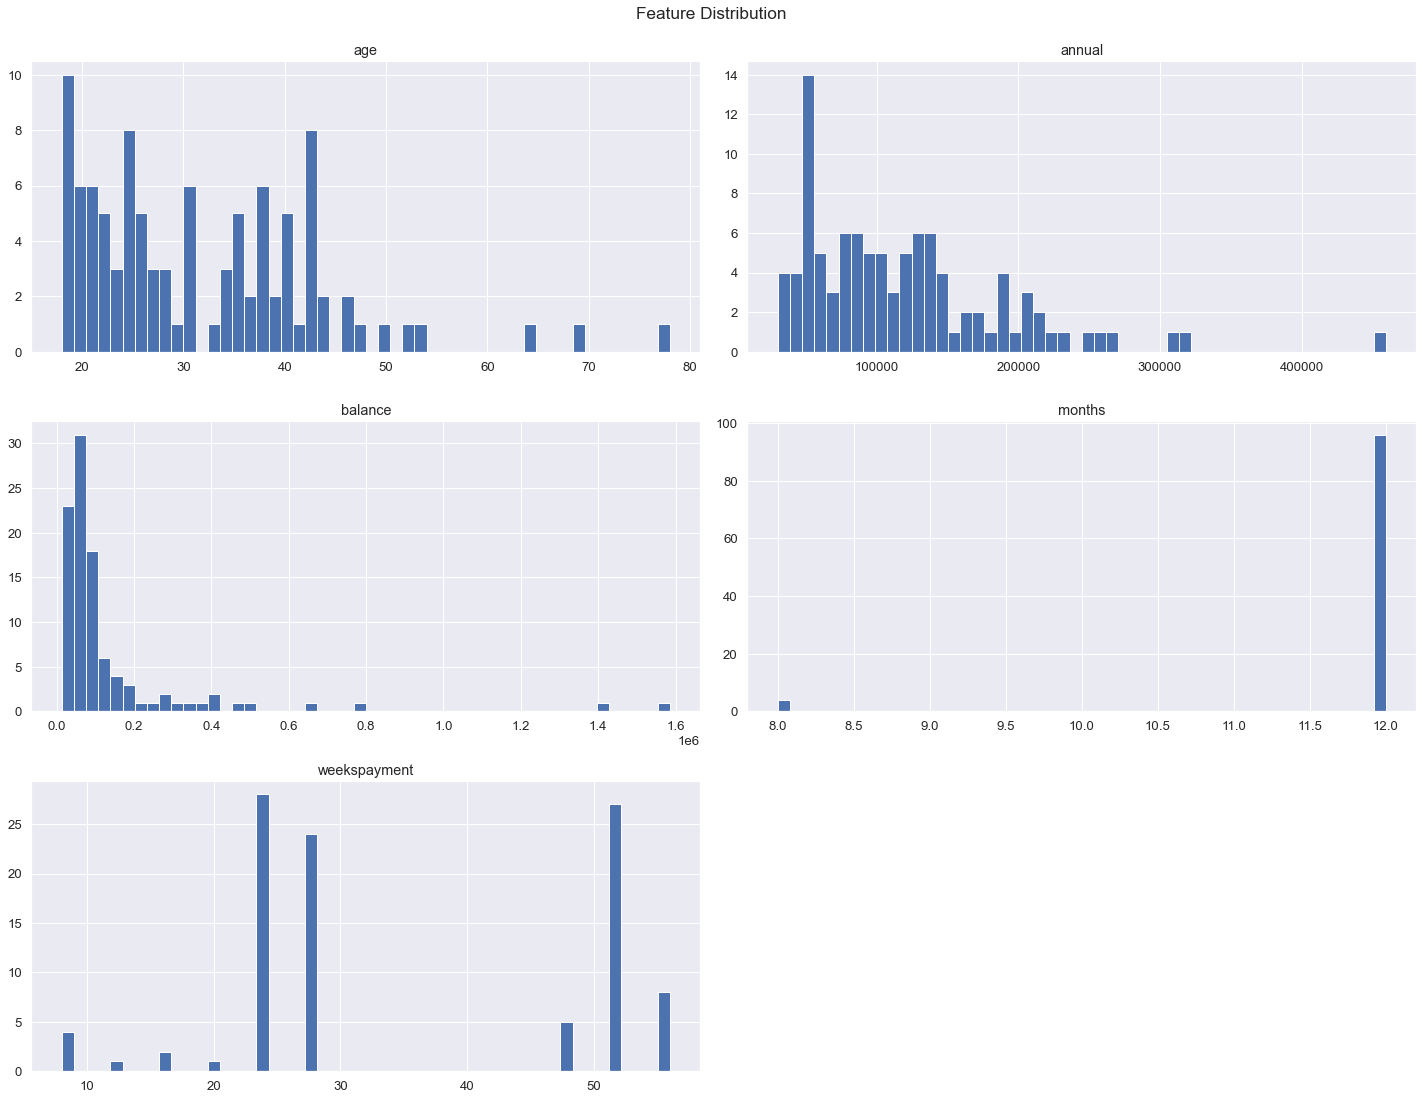

In [8]:
df.hist(bins=50, figsize=(20,15))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

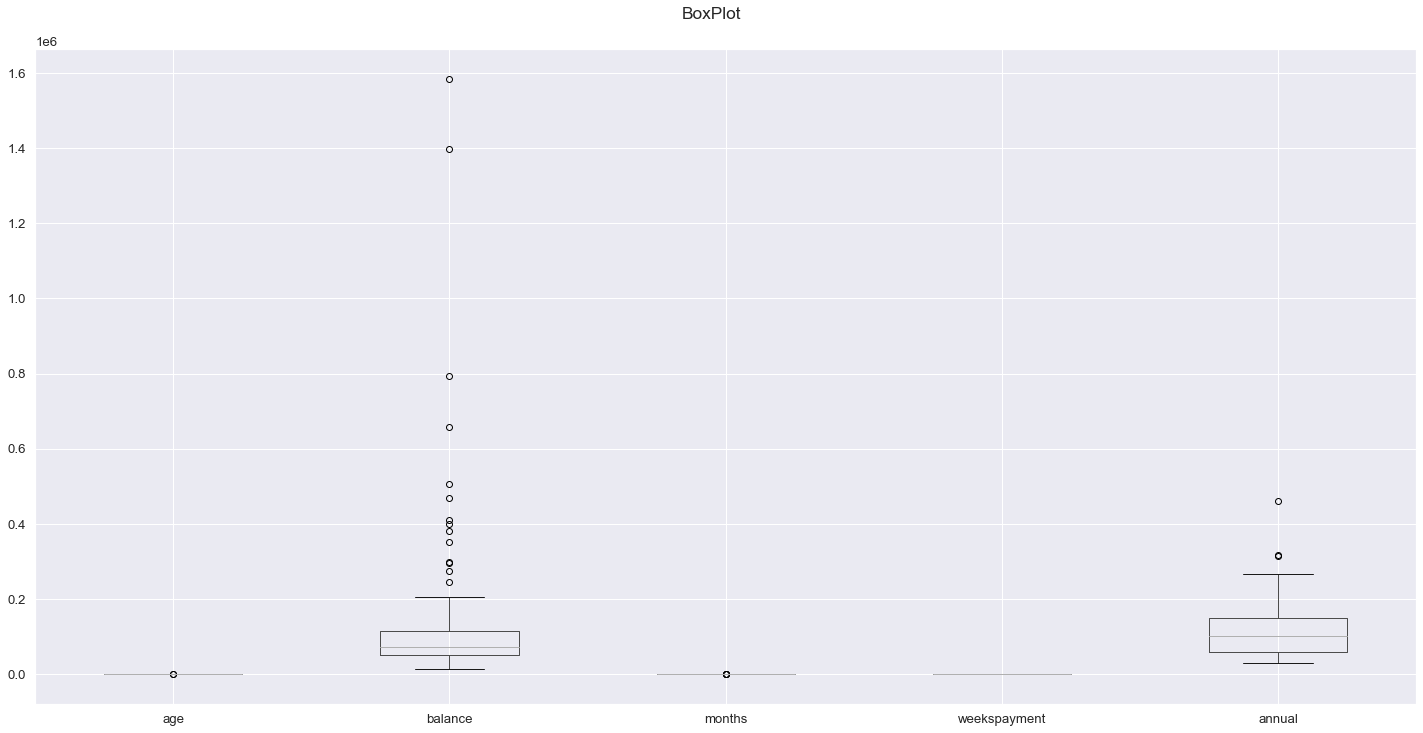

In [9]:
df.boxplot(figsize=(20,10))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

### Correlation

In [10]:
df.corr()

,age,balance,months,weekspayment,annual
age,1.000000,0.289224,0.093653,0.182368,-0.135264
balance,0.289224,1.000000,0.107047,-0.013461,0.101847
months,0.093653,0.107047,1.000000,0.383716,-0.466623
weekspayment,0.182368,-0.013461,0.383716,1.000000,-0.696428
annual,-0.135264,0.101847,-0.466623,-0.696428,1.000000


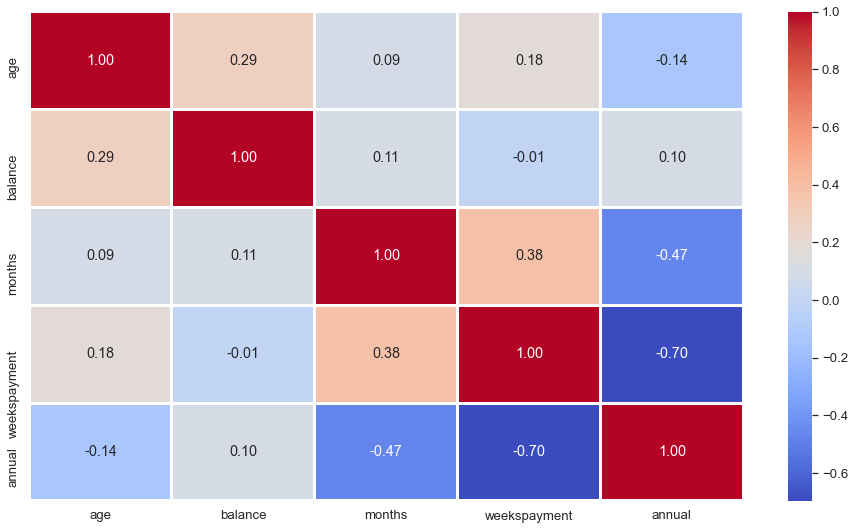

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Pairplots

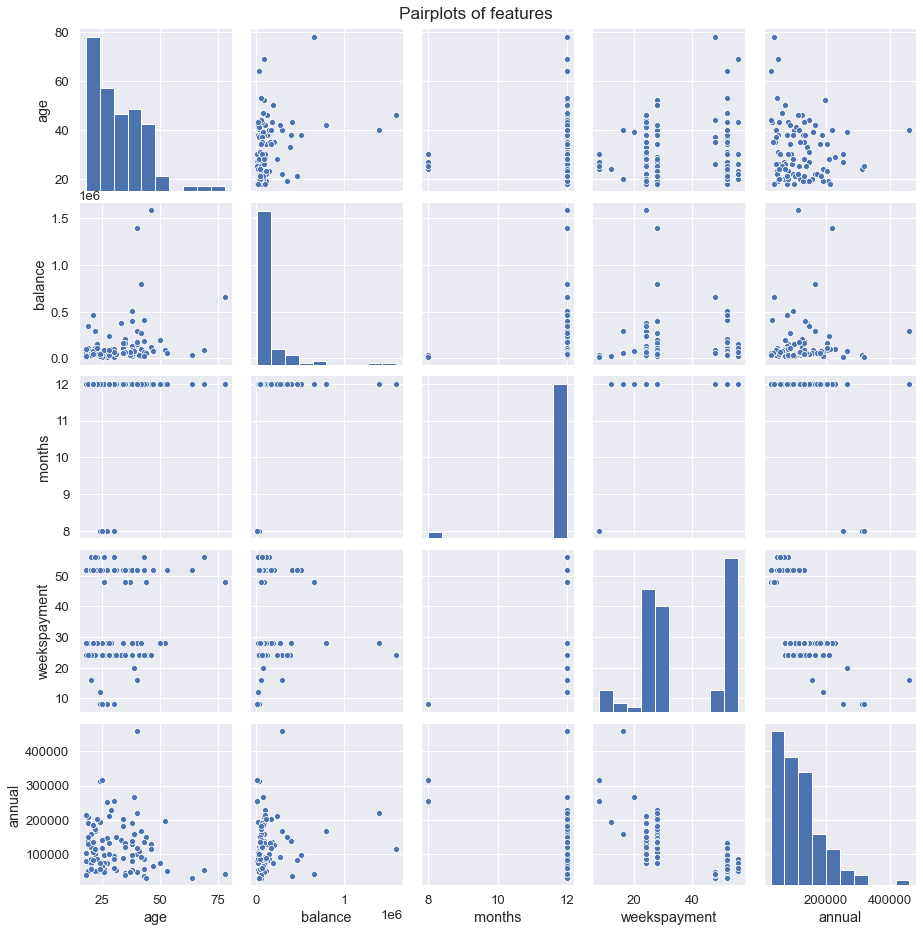

In [12]:
sns.pairplot(df)
plt.suptitle('Pairplots of features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

### Data Preprocessing

### Treat Missing Values

In [13]:
df.isnull().sum()

account         0
first_name      0
age             0
gender          0
balance         0
months          0
weekspayment    0
annual          0
dtype: int64

### Treat Duplicate Values

In [14]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [15]:
df.describe()

,age,balance,months,weekspayment,annual
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,31.770000,1.434244e+05,11.840000,35.320000,119458.242800
std,11.544254,2.350789e+05,0.787786,14.606543,72684.766459
min,18.000000,1.376963e+04,8.000000,8.000000,29952.000000
25%,22.000000,4.965724e+04,12.000000,24.000000,59972.120000
50%,29.500000,7.227742e+04,12.000000,28.000000,101370.360000
75%,39.250000,1.150409e+05,12.000000,52.000000,150109.700000
max,78.000000,1.584768e+06,12.000000,56.000000,459470.960000


In [16]:
df.columns

Index(['account', 'first_name', 'age', 'gender', 'balance', 'months', 'weekspayment', 'annual'], dtype='object')

In [17]:
df.drop(['account', 'first_name'],axis=1,inplace=True)

In [18]:
df

,age,gender,balance,months,weekspayment,annual
0,40,F,51472.20,12,52,46388.68
1,22,M,298308.49,12,24,166140.52
2,52,M,86898.05,12,28,196860.56
3,27,F,13769.63,8,8,252908.24
4,38,M,22826.60,12,52,52110.76
...,...,...,...,...,...,...
95,28,M,88169.32,12,28,132011.36
96,35,M,65301.33,12,24,120050.84
97,34,F,59807.25,12,28,182915.72
98,21,M,467645.22,12,52,81130.40


### Perform One-Hot Encoding

In [19]:
df2 = pd.get_dummies(df, drop_first=True)

In [20]:
df2

,age,balance,months,weekspayment,annual,gender_M
0,40,51472.20,12,52,46388.68,0
1,22,298308.49,12,24,166140.52,1
2,52,86898.05,12,28,196860.56,1
3,27,13769.63,8,8,252908.24,0
4,38,22826.60,12,52,52110.76,1
...,...,...,...,...,...,...
95,28,88169.32,12,28,132011.36,1
96,35,65301.33,12,24,120050.84,1
97,34,59807.25,12,28,182915.72,0
98,21,467645.22,12,52,81130.40,1


In [21]:
df2.columns

Index(['age', 'balance', 'months', 'weekspayment', 'annual', 'gender_M'], dtype='object')

In [22]:
df2 = df2[['age', 'balance', 'months', 'weekspayment','gender_M','annual']]

In [23]:
df2

,age,balance,months,weekspayment,gender_M,annual
0,40,51472.20,12,52,0,46388.68
1,22,298308.49,12,24,1,166140.52
2,52,86898.05,12,28,1,196860.56
3,27,13769.63,8,8,0,252908.24
4,38,22826.60,12,52,1,52110.76
...,...,...,...,...,...,...
95,28,88169.32,12,28,1,132011.36
96,35,65301.33,12,24,1,120050.84
97,34,59807.25,12,28,0,182915.72
98,21,467645.22,12,52,1,81130.40


### Treat Data Types

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           100 non-null    int64  
 1   balance       100 non-null    float64
 2   months        100 non-null    int64  
 3   weekspayment  100 non-null    int64  
 4   gender_M      100 non-null    uint8  
 5   annual        100 non-null    float64
dtypes: float64(2), int64(3), uint8(1)
memory usage: 4.1 KB


### Create and save processed dataset

In [25]:
#df2.to_csv("train.csv",index=False)

### Train Test Split

In [26]:
df2.shape

(100, 6)

In [27]:
X = df2.iloc[:,0:5]
y = df2.iloc[:,5]

In [28]:
X.values, y.values

(array([[     40.  ,   51472.2 ,      12.  ,      52.  ,       0.  ],
        [     22.  ,  298308.49,      12.  ,      24.  ,       1.  ],
        [     52.  ,   86898.05,      12.  ,      28.  ,       1.  ],
        [     27.  ,   13769.63,       8.  ,       8.  ,       0.  ],
        [     38.  ,   22826.6 ,      12.  ,      52.  ,       1.  ],
        [     42.  ,   28575.85,      12.  ,      24.  ,       1.  ],
        [     44.  ,   49934.57,      12.  ,      24.  ,       1.  ],
        [     33.  ,  381472.24,      12.  ,      24.  ,       1.  ],
        [     46.  ,  122866.07,      12.  ,      24.  ,       0.  ],
        [     39.  ,   89270.66,      12.  ,      28.  ,       1.  ],
        [     22.  ,   37087.99,      12.  ,      24.  ,       1.  ],
        [     35.  ,   57016.46,      12.  ,      52.  ,       0.  ],
        [     31.  ,   51803.62,      12.  ,      52.  ,       1.  ],
        [     43.  ,  183287.54,      12.  ,      52.  ,       1.  ],
        [     21.  ,

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 5), (20, 5), (80,), (20,))

### Feature Scaling

In [31]:
X_train

array([[     29.  ,  106299.1 ,      12.  ,      28.  ,       1.  ],
       [     35.  ,  164255.24,      12.  ,      52.  ,       1.  ],
       [     27.  ,   13769.63,       8.  ,       8.  ,       0.  ],
       [     18.  ,   98107.03,      12.  ,      28.  ,       1.  ],
       [     43.  ,  409793.72,      12.  ,      52.  ,       0.  ],
       [     50.  ,  198251.88,      12.  ,      28.  ,       0.  ],
       [     44.  ,   49934.57,      12.  ,      24.  ,       1.  ],
       [     21.  ,   49877.75,      12.  ,      28.  ,       1.  ],
       [     26.  ,   94134.87,      12.  ,      48.  ,       0.  ],
       [     38.  ,  506145.72,      12.  ,      52.  ,       1.  ],
       [     25.  ,   16864.59,       8.  ,       8.  ,       1.  ],
       [     21.  ,   83700.42,      12.  ,      28.  ,       1.  ],
       [     40.  ,  171879.76,      12.  ,      52.  ,       1.  ],
       [     24.  ,   27141.67,      12.  ,      28.  ,       1.  ],
       [     53.  ,   61342.65,   

In [32]:
scaler = StandardScaler()

In [33]:
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled

array([[-0.18982307, -0.18390253,  0.19738551, -0.50337646,  0.90453403],
       [ 0.34931937,  0.0413495 ,  0.19738551,  1.15155984,  0.90453403],
       [-0.36953721, -0.5435271 , -5.06622805, -1.88249003, -1.1055416 ],
       [-1.17825087, -0.21574179,  0.19738551, -0.50337646,  0.90453403],
       [ 1.06817596,  0.9956581 ,  0.19738551,  1.15155984, -1.1055416 ],
       [ 1.69717547,  0.17348067,  0.19738551, -0.50337646, -1.1055416 ],
       [ 1.15803303, -0.40296863,  0.19738551, -0.77919917,  0.90453403],
       [-0.90867965, -0.40318946,  0.19738551, -0.50337646,  0.90453403],
       [-0.45939429, -0.23117997,  0.19738551,  0.87573712, -1.1055416 ],
       [ 0.61889059,  1.37013929,  0.19738551,  1.15155984,  0.90453403],
       [-0.54925136, -0.53149824, -5.06622805, -1.88249003,  0.90453403],
       [-0.90867965, -0.27173445,  0.19738551, -0.50337646,  0.90453403],
       [ 0.79860474,  0.07098292,  0.19738551,  1.15155984,  0.90453403],
       [-0.63910843, -0.4915554 ,  0.1

In [36]:
X_test_scaled

array([[ 0.61889059, -0.23597265,  0.19738551, -0.77919917,  0.90453403],
       [ 0.34931937, -0.38443136,  0.19738551,  0.87573712, -1.1055416 ],
       [ 1.87688962, -0.25930656,  0.19738551, -0.50337646,  0.90453403],
       [ 3.40445986, -0.23060312,  0.19738551,  1.42738255,  0.90453403],
       [ 0.52903352, -0.3171104 ,  0.19738551,  0.87573712,  0.90453403],
       [-0.09996599, -0.3194005 ,  0.19738551,  1.42738255, -1.1055416 ],
       [-1.17825087, -0.52912023,  0.19738551, -0.77919917, -1.1055416 ],
       [-0.27968014,  0.35284733,  0.19738551, -0.77919917,  0.90453403],
       [-0.81882258, -0.36725832,  0.19738551, -0.50337646,  0.90453403],
       [-0.27968014, -0.25436564,  0.19738551, -0.50337646,  0.90453403],
       [-0.72896551, -0.33761192,  0.19738551,  1.15155984,  0.90453403],
       [-0.27968014, -0.46081768,  0.19738551, -0.77919917,  0.90453403],
       [ 1.42760425, -0.30197255,  0.19738551,  1.15155984, -1.1055416 ],
       [ 1.06817596,  0.11532034,  0.1

### Model Training

### Using PyCaret

In [37]:
exp_reg = setup(data = df2, target = 'annual', session_id=0, normalize=True, train_size=0.8,
       numeric_features=['months','weekspayment'],categorical_features=['gender_M']) 

 
Setup Succesfully Completed.


,Description,Value
0,session_id,0
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(100, 6)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [38]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Random Forest,29301.5291,2163230089.6387,42515.7030,0.3529,0.3022,0.2724,0.1758
1,Extra Trees Regressor,30909.3561,2334604919.2863,43150.5733,0.3501,0.3118,0.2863,0.1388
2,AdaBoost Regressor,32635.1157,2127994922.1505,42943.7651,0.3479,0.3456,0.3309,0.0767
3,Gradient Boosting Regressor,33365.8582,2111731316.6444,43646.7740,0.3123,0.3464,0.3276,0.0417
4,Extreme Gradient Boosting,32658.4512,2493513976.4447,46506.4956,0.3076,0.3346,0.2863,0.0910
5,CatBoost Regressor,32752.6319,2563181216.0432,44846.5924,0.2778,0.3548,0.3265,0.7928
6,Elastic Net,38823.9344,3099121552.3342,50633.3856,0.2085,0.4152,0.4046,0.0053
7,Random Sample Consensus,36678.6640,3169982088.6563,51390.4456,0.2040,0.3875,0.3116,0.0752
8,Huber Regressor,36626.1631,3066209514.8814,50086.0571,0.1856,0.3800,0.3248,0.0100
9,Orthogonal Matching Pursuit,39774.7737,3078734214.2651,51049.8354,0.1016,0.4021,0.3714,0.0016


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

### Simple Regression Model

In [39]:
lr = LinearRegression()

In [40]:
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
lr_pred = lr.predict(X_test_scaled)

In [42]:
lr_pred

array([145019.66871768,  70166.40490483, 127494.26832432,  38474.65966601,
        73716.71187725,  49173.18928733, 146180.56661006, 155001.58108455,
       138113.88238077, 136931.33224313,  67170.98898244, 146612.28747075,
        54513.95717847,  64019.18015509, 158538.92082806, 143956.72181563,
       136841.75957281,  54146.26294868, 289980.84667239, 139453.3436494 ])

In [44]:
y_test

array([189774.52,  37716.64, 196860.56,  54242.24,  47671.  ,  60223.8 ,
        79959.36, 210848.04, 173096.04, 132011.36,  51100.92,  99658.52,
        66168.44, 134576.52, 141362.52,  91406.12, 206827.92,  72565.48,
       255366.8 , 128463.4 ])

In [45]:
mse = mean_squared_error(y_test,lr_pred)
mse

1742935754.6537423

In [46]:
rmse = np.sqrt(mse)
rmse

41748.48206406722

In [47]:
r2score = r2_score(y_test,lr_pred)
r2score

0.5706038490094812

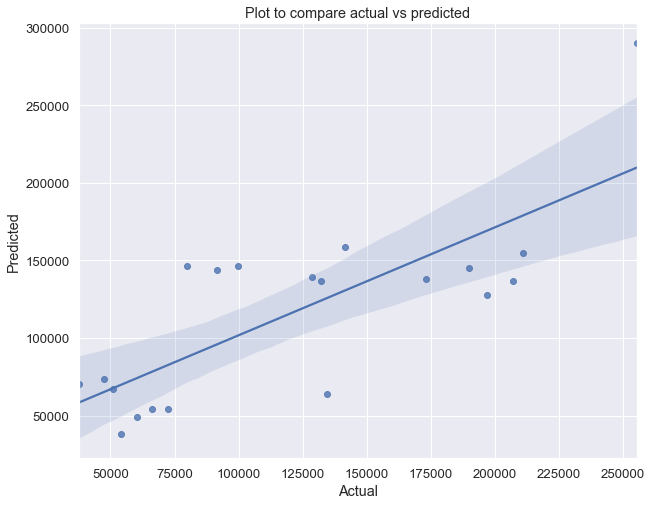

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=lr_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Using XGBoost (Scikit-Learn)

### Using RandomSearchCV

In [49]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [50]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,10,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1),
              'reg_alpha':np.arange(0,1,0.1),
              'reg_lambda':np.arange(0,1,0.1)
             }

In [51]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='neg_mean_squared_error',random_state=0)

In [52]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'min_child_weight': array([1, 2, 3]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
  

In [53]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.15000000000000002, learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0.4, reg_lambda=0.1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
randm.best_score_

-2594910809.860133

In [55]:
randm.best_params_

{'subsample': 0.6,
 'reg_lambda': 0.1,
 'reg_alpha': 0.4,
 'n_estimators': 800,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning rate': 0.15000000000000002,
 'gamma': 2,
 'colsample_bytree': 0.5}

### Final Model

In [56]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror', subsample=0.7,
                        reg_lambda=0.4,reg_alpha=0.2,min_child_weight=1,max_depth=4,eta=0.25, gamma=4,
                        colsample_bytree=0.8)

In [57]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:108464.35156
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:87001.39062
[2]	validation_0-rmse:71516.21094
[3]	validation_0-rmse:62403.91797
[4]	validation_0-rmse:52160.75391
[5]	validation_0-rmse:45983.89453
[6]	validation_0-rmse:42712.09766
[7]	validation_0-rmse:40499.71484
[8]	validation_0-rmse:39906.14453
[9]	validation_0-rmse:39556.49609
[10]	validation_0-rmse:39097.35156
[11]	validation_0-rmse:40342.96875
[12]	validation_0-rmse:40113.82031
[13]	validation_0-rmse:39186.51562
[14]	validation_0-rmse:40743.67578
[15]	validation_0-rmse:41439.43359
[16]	validation_0-rmse:41451.07812
[17]	validation_0-rmse:41661.97656
[18]	validation_0-rmse:42399.53516
[19]	validation_0-rmse:42048.81250
[20]	validation_0-rmse:41679.58594
Stopping. Best iteration:
[10]	validation_0-rmse:39097.35156



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.25, gamma=4,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.2,
             reg_lambda=0.4, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
y_pred = xgbmodel.predict(X_test_scaled)

In [59]:
y_pred

array([123855.125,  53267.34 ,  98036.33 ,  44264.766,  53234.176,
        60758.426, 116717.98 , 142476.62 , 127761.93 , 158373.56 ,
        55660.65 , 100023.43 ,  50072.734,  78182.79 , 143733.55 ,
       138132.31 , 169413.12 ,  67922.88 , 247472.95 , 115087.48 ],
      dtype=float32)

### Model Evaluation

In [60]:
mse = mean_squared_error(y_test,y_pred)
mse

1528602724.8495464

In [61]:
rmse = np.sqrt(mse)
rmse

39097.34933278146

In [62]:
r2score = r2_score(y_test,y_pred)
r2score

0.6234077333651278

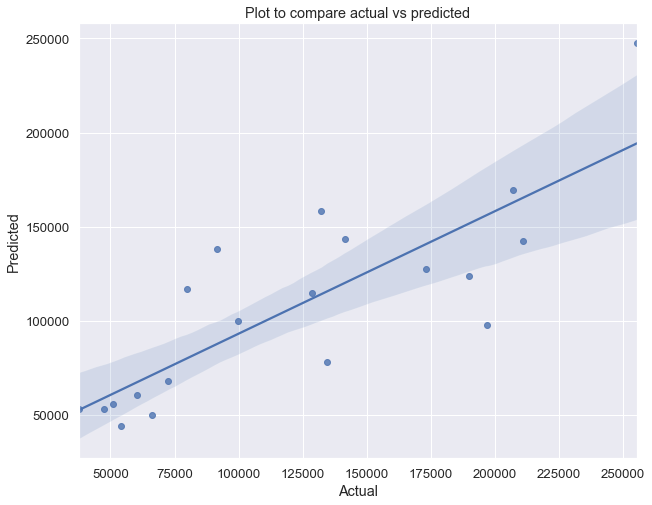

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [64]:
X.columns

Index(['age', 'balance', 'months', 'weekspayment', 'gender_M'], dtype='object')

In [65]:
xgbmodel.get_booster().feature_names = ['age', 'balance', 'months', 'weekspayment', 'gender_M_0']

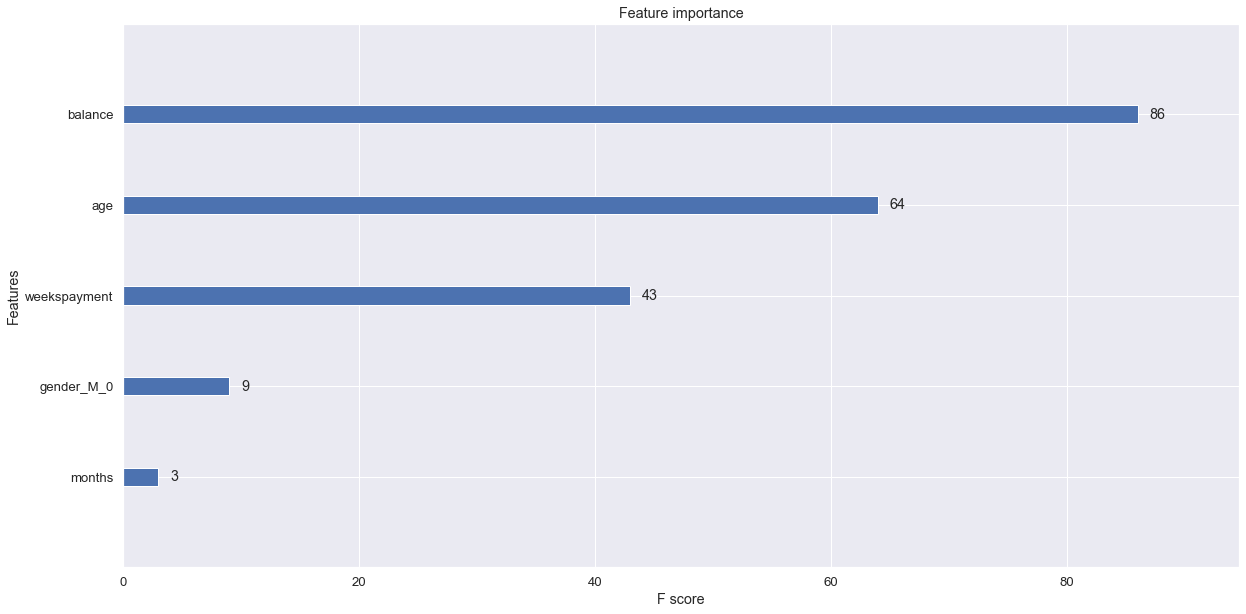

In [66]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

### Cross-Validation

In [67]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [68]:
cv.mean()

0.4714286293167129

### Save the Model

In [69]:
filename = 'anzmodel.sav'
dump(xgbmodel,open(filename,'wb'))

### Conclusion: Tree based model is much better in accuracy than linear regression.